# 10. Denoising Autoencoder for Image Classifier pretraining

_Exercise: Try using a denoising autoencoder to pretrain an image classifier. You can use MNIST (the simplest option), or a more complex image dataset such as [CIFAR10](https://homl.info/122) if you want a bigger challenge. Regardless of the dataset you're using, follow these steps:_
* Split the dataset into a training set and a test set. Train a deep denoising autoencoder on the full training set.
* Check that the images are fairly well reconstructed. Visualize the images that most activate each neuron in the coding layer.
* Build a classification DNN, reusing the lower layers of the autoencoder. Train it using only 500 images from the training set. Does it perform better with or without pretraining?

## Prepare environment

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import keras
from keras import layers

from matplotlib import pyplot as plt

import numpy as np

2025-03-25 17:58:05.308941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742921885.330418  159681 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742921885.336935  159681 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-25 17:58:05.359176: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

## MNIST

### Split the dataset into a training set and a test set.

In [ ]:
train, test = tfds.as_numpy(
    tfds.load(
        "mnist",
        split=["train", "test"],
        shuffle_files=True,
        as_supervised=True,
        batch_size=-1,
    )
)

In [ ]:
X_train_full, y_train_full, X_test, y_test = train[0], train[1], test[0], test[1]

In [ ]:
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [ ]:
for image in X_train[:5]:
  print(image.shape)

In [ ]:
for image in X_test[:5]:
  print(image.shape)

In [ ]:
y_train[:5]

In [ ]:
y_test[:5]

### Train a deep denoising autoencoder on the full training set.

In [ ]:
dropout_encoder = keras.Sequential([
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(100, activation="relu"),
    layers.Dense(30, activation="relu")
])
dropout_decoder = keras.Sequential([
    layers.Dense(100, activation="relu"),
    layers.Dense(28 * 28),
    layers.Reshape([28, 28])
])
dropout_ae = keras.Sequential([dropout_encoder, dropout_decoder])

dropout_ae.compile(loss="mse", optimizer="nadam")
history = dropout_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

### Check that the images are fairly well reconstructed

In [13]:
def plot_reconstructions(model, images, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

In [ ]:
dropout = layers.Dropout(0.5)
plot_reconstructions(dropout_ae, dropout(X_test, training=True))
plt.show()

### Visualize the images that most activate each neuron in the coding layer

In [24]:
def select_representative_images(x_test, y_test):
    """
    Select one representative image for each digit class
    
    Args:
        x_test (np.array): Test images
        y_test (np.array): Test labels
    
    Returns:
        tuple: Selected images and their corresponding labels
    """
    # Unique classes (0-9)
    classes = np.unique(y_test)
    
    # Storage for selected images
    selected_images = []
    selected_labels = []
    
    for digit in classes:
        # Find indices of images with this digit
        digit_indices = np.where(y_test == digit)[0]
        
        # Select first image of this digit (you could use random selection too)
        first_image_index = digit_indices[0]
        
        selected_images.append(x_test[first_image_index])
        selected_labels.append(y_test[first_image_index])
    
    return (np.array(selected_images), np.array(selected_labels))

def visualize_neuron_activations_per_class(encoder, x_test, y_test):
    """
    Visualize neuron activations for representative images of each class
    
    Args:
        encoder (keras.Model): Trained encoder model
        x_test (np.array): Test images
        y_test (np.array): Test labels
    """
    # Select one image per class
    class_images, class_labels = select_representative_images(x_test, y_test)
    
    # Get neuron activations for these images
    activations = encoder.predict(class_images)
    
    # Visualization
    plt.figure(figsize=(15, 6))
    
    # Images
    for i in range(len(class_images)):
        plt.subplot(2, 10, i + 1)
        plt.imshow(class_images[i].squeeze(), cmap='gray')
        plt.title(f'Digit: {class_labels[i]}')
        plt.axis('off')
    
    # Neuron Activations
    plt.subplot(2, 1, 2)
    plt.imshow(activations, aspect='auto', cmap='viridis')
    plt.title('Neuron Activations per Digit Class')
    plt.xlabel('Neuron Index')
    plt.ylabel('Digit Class')
    plt.colorbar(label='Activation Strength')
    
    # Add class labels to y-axis
    plt.yticks(range(len(class_labels)), [str(label) for label in class_labels])
    plt.xticks(range(len(activations[0])))
    
    plt.tight_layout()
    plt.show()

In [ ]:
visualize_neuron_activations_per_class(dropout_encoder, X_test, y_test)

### Build a classification DNN, reusing the lower layers of the autoencoder.

In [ ]:
num_classes = len(np.unique(y_test))
num_classes

In [ ]:
model = keras.Sequential()

dropout_encoder.trainable = False
model.add(dropout_encoder)

for _ in range(20):
    model.add(layers.Dense(100, kernel_initializer="he_normal"))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("swish"))

model.add(layers.Dense(num_classes, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

### Train it using only 500 images from the training set.

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True
)

model.fit(
    X_train[:500],
    y_train[:500],
    epochs=100,
    validation_data=(X_valid[:500], y_valid[:500]),
    callbacks=[early_stopping_cb],
)

### Does it perform better with or without pretraining?

In [ ]:
model_without_pretraining = keras.Sequential()

model_without_pretraining.add(layers.Flatten())

for _ in range(20):
    model_without_pretraining.add(layers.Dense(100, kernel_initializer="he_normal"))
    model_without_pretraining.add(layers.BatchNormalization())
    model_without_pretraining.add(layers.Activation("swish"))

model_without_pretraining.add(layers.Dense(num_classes, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model_without_pretraining.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True
)

model_without_pretraining.fit(
    X_train[:500],
    y_train[:500],
    epochs=100,
    validation_data=(X_valid[:500], y_valid[:500]),
    callbacks=[early_stopping_cb],
)

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
model_without_pretraining.evaluate(X_test, y_test)

# CIFAR10

In [3]:
train, test = tfds.as_numpy(
    tfds.load(
        "cifar10",
        split=["train", "test"],
        shuffle_files=True,
        as_supervised=True,
        batch_size=-1,
    )
)

I0000 00:00:1742921895.868859  159681 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2874 MB memory:  -> device: 0, name: Quadro P600, pci bus id: 0000:01:00.0, compute capability: 6.1
2025-03-25 17:58:17.021701: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


In [4]:
X_train_full, y_train_full, X_test, y_test = train[0], train[1], test[0], test[1]

In [5]:
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

Convolutional Autoencoder architecture from:
https://github.com/chenjie/PyTorch-CIFAR-10-autoencoder/blob/master/main.py

In [46]:
dropout_encoder = keras.Sequential(
    [
        layers.Dropout(0.5),
        layers.Reshape([32, 32, 3]),
        layers.Conv2D(12, 4, strides=2, padding="same", activation="relu"),
        layers.Conv2D(24, 4, strides=2, padding="same", activation="relu"),
        layers.Conv2D(48, 4, strides=2, padding="same", activation="relu"),
    ]
)
dropout_decoder = keras.Sequential(
    [
        layers.Conv2DTranspose(24, 4, strides=2, padding="same", activation="relu"),
        layers.Conv2DTranspose(12, 4, strides=2, padding="same", activation="relu"),
        layers.Conv2DTranspose(3, 4, strides=2, padding="same", activation="sigmoid"),
    ]
)
dropout_ae = keras.Sequential([dropout_encoder, dropout_decoder])

dropout_ae.compile(loss="binary_crossentropy", optimizer="adam", metrics=["mse"])

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True
)

In [47]:
history = dropout_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid), callbacks=[early_stopping_cb])

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.6115 - mse: 0.0260 - val_loss: 0.6477 - val_mse: 0.0429
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.5772 - mse: 0.0111 - val_loss: 0.7129 - val_mse: 0.0722
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.5734 - mse: 0.0096 - val_loss: 0.7702 - val_mse: 0.0960
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.5694 - mse: 0.0080 - val_loss: 0.7790 - val_mse: 0.0934
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.5665 - mse: 0.0069 - val_loss: 0.7790 - val_mse: 0.0903
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.5646 - mse: 0.0061 - val_loss: 0.7945 - val_mse: 0.0973
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.5633 - mse: 0.0057 - val_loss: 0.7742 - val_mse: 0.0941
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.5626 - mse: 0.0054 - val_loss: 0.7701 - val_mse: 0.0951
Epoch 9/10
1407/1407 ━━━━━━━━━━━

Epoch 10/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.5557 - mse: 0.0027 - val_loss: 0.5541 - val_mse: 0.0025

In [40]:
dropout_ae.summary(expand_nested=True)

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_15 (Sequential)      │ (None, 48)             │        23,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ reshape_8 (Reshape)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2d_14 (Conv2D)         │ (None, 16, 16, 12)     │           588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2d_15 (Conv2D)         │ (None, 8, 8, 24)       │         4,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2d_16 (Conv2D)         │ (None, 4, 4, 48)       │        18,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ global_average_pooling2d_4 │ (None, 48)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_16 (Sequential)      │ (None, 32, 32, 3)      │        23,911 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense_65 (Dense)           │ (None, 256)            │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ reshape_9 (Reshape)        │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2d_transpose_12        │ (None, 8, 8, 24)       │         6,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2d_transpose_13        │ (None, 16, 16, 12)     │         4,620 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2d_transpose_14        │ (None, 32, 32, 3)      │           579 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,835 (557.95 KB)

 Trainable params: 47,611 (185.98 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 95,224 (371.97 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


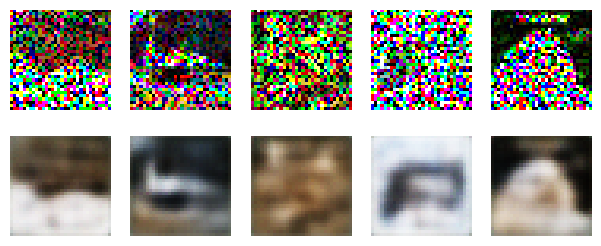

In [48]:
dropout = layers.Dropout(0.5)
plot_reconstructions(dropout_ae, dropout(X_test, training=True))
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


TypeError: Invalid shape (10, 4, 4, 48) for image data

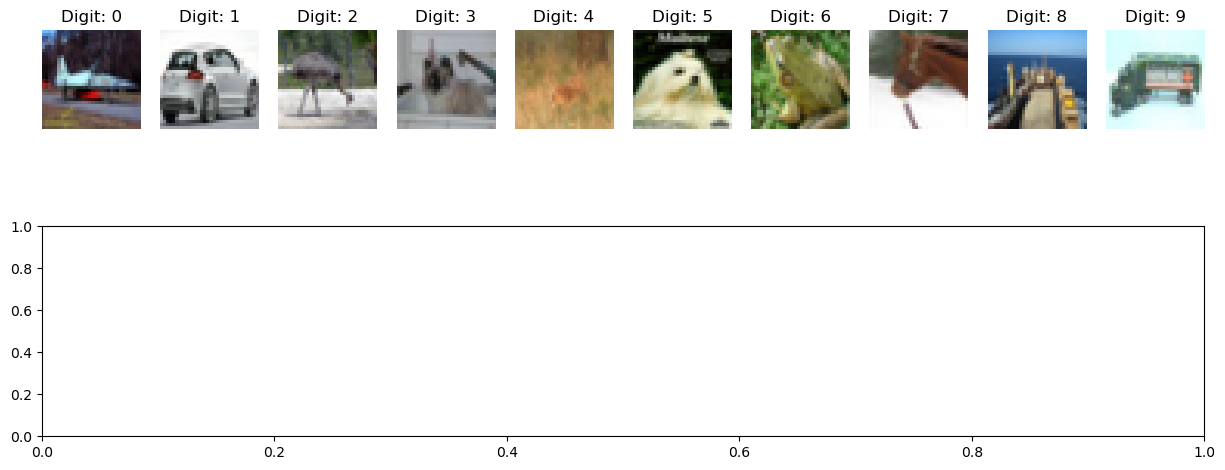

In [49]:
visualize_neuron_activations_per_class(dropout_encoder, X_test, y_test)

In [26]:
num_classes = len(np.unique(y_test))
num_classes

10

In [50]:
model = keras.Sequential()

dropout_encoder.trainable = False
model.add(dropout_encoder)
model.add(keras.layers.GlobalAvgPool2D())

for _ in range(20):
    model.add(layers.Dense(100, kernel_initializer="he_normal"))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("swish"))

model.add(layers.Dense(num_classes, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

In [51]:
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True
)

model.fit(
    X_train[:500],
    y_train[:500],
    epochs=100,
    validation_data=(X_valid[:500], y_valid[:500]),
    callbacks=[early_stopping_cb],
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 465ms/step - accuracy: 0.1261 - loss: 2.5582 - val_accuracy: 0.0960 - val_loss: 2.3042
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0839 - loss: 2.5034 - val_accuracy: 0.0960 - val_loss: 2.3058
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1313 - loss: 2.4024 - val_accuracy: 0.0960 - val_loss: 2.3072
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1437 - loss: 2.3736 - val_accuracy: 0.1120 - val_loss: 2.3094
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1673 - loss: 2.2962 - val_accuracy: 0.1160 - val_loss: 2.3121
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1291 - loss: 2.2971 - val_accuracy: 0.0800 - val_loss: 2.3154
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1681 - loss: 2.2549 - val_accuracy: 0.0800 - val_loss: 2.3191
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1830 - loss: 2.2606 - val_accuracy: 

In [33]:
model_without_pretraining = keras.Sequential()

model_without_pretraining.add(layers.Flatten())

for _ in range(20):
    model_without_pretraining.add(layers.Dense(100, kernel_initializer="he_normal"))
    model_without_pretraining.add(layers.BatchNormalization())
    model_without_pretraining.add(layers.Activation("swish"))

model_without_pretraining.add(layers.Dense(num_classes, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model_without_pretraining.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

In [34]:
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True
)

model_without_pretraining.fit(
    X_train[:500],
    y_train[:500],
    epochs=100,
    validation_data=(X_valid[:500], y_valid[:500]),
    callbacks=[early_stopping_cb],
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 422ms/step - accuracy: 0.0931 - loss: 2.5822 - val_accuracy: 0.0880 - val_loss: 2.3051
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1241 - loss: 2.4614 - val_accuracy: 0.1060 - val_loss: 2.5646
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1439 - loss: 2.4235 - val_accuracy: 0.1000 - val_loss: 2.7021
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1424 - loss: 2.3057 - val_accuracy: 0.0900 - val_loss: 3.0477
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1490 - loss: 2.2765 - val_accuracy: 0.0760 - val_loss: 3.0296
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1922 - loss: 2.2242 - val_accuracy: 0.0980 - val_loss: 2.7533
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2109 - loss: 2.1821 - val_accuracy: 0.1040 - val_loss: 2.9942
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2502 - loss: 2.0956 - val_accuracy: 

In [45]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0983 - loss: 2.3033


[2.30303692817688, 0.09929999709129333]

In [35]:
model_without_pretraining.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1100 - loss: 2.3026


[2.3029661178588867, 0.10890000313520432]